In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.windows import Window

## **Exploratory Data Anlysis**

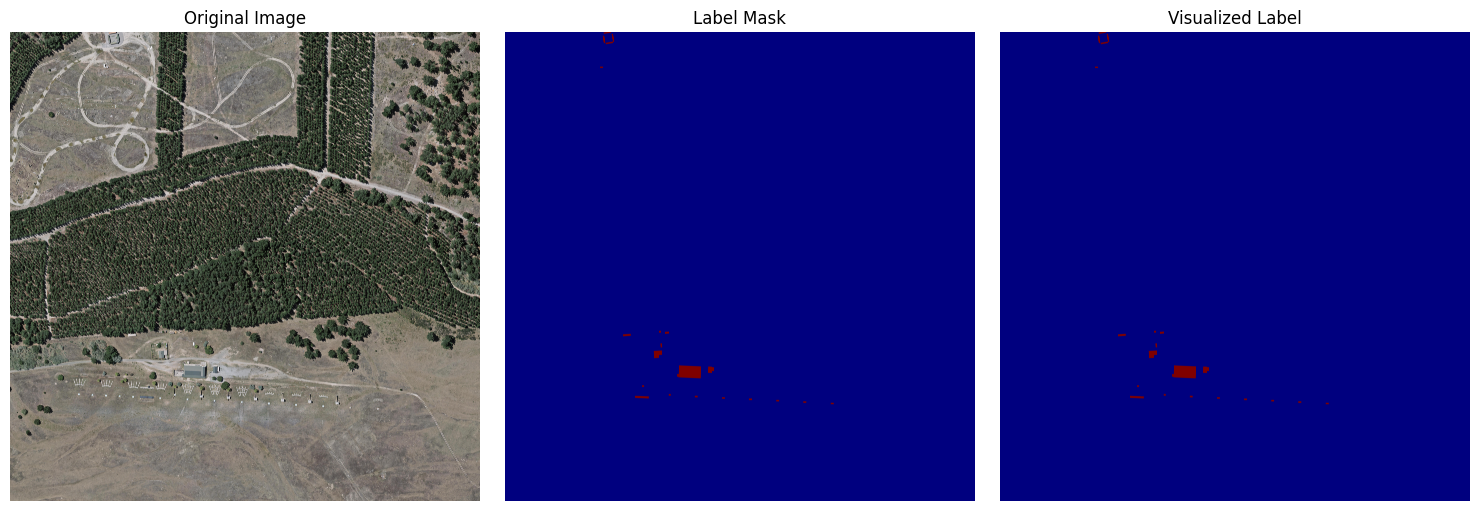

In [3]:
img_id = 30

with rasterio.open(f"data\\train\\image\\christchurch_{img_id}.tif") as src:
    img = src.read()
    
with rasterio.open(f"data\\train\\label\\christchurch_{img_id}.tif") as src:
    label = src.read()
    
with rasterio.open(f"data\\train\\label\\christchurch_{img_id}_vis.tif") as src:
    label_vis = src.read()
    

# Create figure
plt.figure(figsize=(15, 5))

# Plot 1: Original Image (RGB)
plt.subplot(1, 3, 1)
if img.shape[0] == 3:  # If RGB image
    plt.imshow(img.transpose(1, 2, 0))  # Convert from (C,H,W) to (H,W,C)
else:  # If single channel
    plt.imshow(img[0], cmap='gray')  # Show first band
plt.title("Original Image")
plt.axis('off')

# Plot 2: Label Mask
plt.subplot(1, 3, 2)
if len(label.shape) == 3:
    plt.imshow(label[0], cmap='jet')  # Show first band of label
else:
    plt.imshow(label, cmap='jet')
plt.title("Label Mask")
plt.axis('off')

# Plot 3: Visualized Label
plt.subplot(1, 3, 3)
if label_vis.shape[0] == 3:  # If RGB
    plt.imshow(label_vis.transpose(1, 2, 0))
else:  # If single channel
    plt.imshow(label_vis[0], cmap='jet')
plt.title("Visualized Label")
plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
print(img.shape, label.shape, label_vis.shape)

(3, 10000, 10000) (1, 10000, 10000) (1, 10000, 10000)


In [5]:
img.min(), img.max()

(np.uint8(0), np.uint8(255))

## **Patch Process Test**

In [6]:
# Generator Function

def get_patches(img_path, mask_path, lib="torch", augment=False):
    """
    Generate image-mask patch pairs from large TIFF files with optional augmentation.
    
    Args:
        img_path: Path to input image TIFF
        mask_path: Path to ground truth mask TIFF
        lib: "torch" (CHW format) or "tf" (HWC format)
        augment: Whether to apply data augmentation
    
    Yields:
        (image_patch, mask_patch) tuples
    """

    PATCH_SIZE = 256
    STRIDE = 128
    
    with rasterio.open(img_path) as img_src, rasterio.open(mask_path) as mask_src:
        # Verify both files have same dimensions
        assert img_src.shape == mask_src.shape, "Image and mask dimensions must match"
        
        height, width = img_src.shape
        
        for x in range(0, width - PATCH_SIZE + 1, STRIDE):
            for y in range(0, height - PATCH_SIZE + 1, STRIDE):
                window = Window(x, y, PATCH_SIZE, PATCH_SIZE)
                
                # Read image and mask patches
                img_patch = img_src.read(window=window)
                mask_patch = mask_src.read(1, window=window)  # Read first band
                
                # Convert mask to binary and add channel dim
                mask_patch = (mask_patch > 0).astype('float32')[..., np.newaxis]
                
                # Normalize and format image
                img_patch = img_patch.astype('float32') / 255.0
                if lib == "tf":
                    img_patch = np.moveaxis(img_patch, 0, -1)  # CHW -> HWC
                
                if augment:
                    print("augmenting....")
                    # img_patch, mask_patch = apply_augmentations(img_patch, mask_patch)
                
                yield img_patch, mask_patch


In [7]:
import rasterio
import numpy as np
import torch
from torch.utils.data import Dataset
from rasterio.windows import Window

class RoofDataset(Dataset):
    def __init__(self, img_path, mask_path, patch_size=256, stride=128, augment=False):
        """
        PyTorch Dataset for roof segmentation from TIFF files.
        
        Args:
            img_path: Path to input image TIFF
            mask_path: Path to ground truth mask TIFF
            patch_size: Size of square patches (default: 256)
            stride: Step size between patches (default: 128)
            augment: Whether to apply data augmentation
        """
        self.img_path = img_path
        self.mask_path = mask_path
        self.patch_size = patch_size
        self.stride = stride
        self.augment = augment

        with rasterio.open(img_path) as img_src, rasterio.open(mask_path) as mask_src:
            self.height = img_src.height
            self.width = img_src.width
            self.n_patches_x = (self.width - self.patch_size) // self.stride + 1
            self.n_patches_y = (self.height - self.patch_size) // self.stride + 1

        # Cache window positions to avoid recomputation - NEW FOR ME
        self.windows = [
            Window(x, y, patch_size, patch_size)
            for x in range(0, self.width - patch_size + 1, stride)
            for y in range(0, self.height - patch_size + 1, stride)
        ]

    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        window =  self.windows[idx]

        with rasterio.open(self.img_path) as img_src, \
             rasterio.open(self.mask_path) as mask_src:
            
            # Read image path [C, H, W], torch expects float32 tensors
            img_patch = img_src.read(window=window).astype('float32')/255
            print(img_patch.max(), img_patch.min())
            # Verify normalisation:
            assert img_patch.max() <= 1 and img_patch.min() >= 0 
            f"Image values out of range [{img_patch.min()}, {img_patch.max()}]"

            # Read mask path
            mask_patch = mask_src.read(1, window=window) > 0
            mask_patch = mask_patch.astype('float32') 

        if self.augment:
            print("Augmenting")

        img_tensor = torch.from_numpy(img_patch)
        mask_tensor = torch.from_numpy(mask_patch).unsqueeze(0) # Adds a channel

        return img_tensor, mask_tensor

In [8]:
# Usage Example
dataset = RoofDataset(
    img_path="data/train/image/christchurch_30.tif",
    mask_path="data/train/label/christchurch_30.tif",
    patch_size=512,
    stride=512,
    augment=True
)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,  # Parallel data loading
    pin_memory=True  # Faster GPU transfer
)

0.89411765 0.0
Augmenting
torch.Size([3, 512, 512])


361

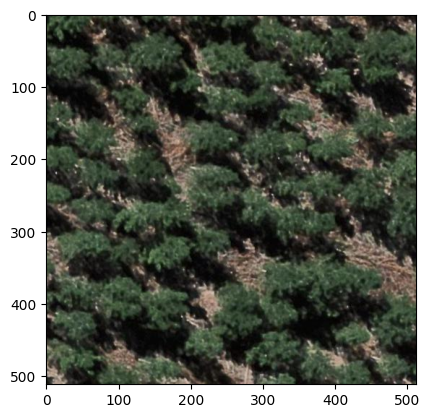

In [14]:
x, y = dataset[10]
plt.imshow(x.T)
print(x.shape)
len(dataset)

In [72]:
import os
import rasterio
from rasterio.windows import Window
import numpy as np
import torch
from torch.utils.data import Dataset

class MultiFileRoofDataset(Dataset):
    def __init__(self, img_dir, mask_dir, patch_size=512, stride=256, augment=False):
        """
        Improved dataset class that properly handles:
        - Correct path joining
        - Proper file filtering
        - Window computation
        - File pairing
        
        Args:
            img_dir: Relative path to image directory
            mask_dir: Relative path to mask directory
            patch_size: Size of square patches
            stride: Step between patches
            augment: Whether to apply data augmentation
        """
        # Proper path handling using os.path.join()
        self.img_dir = os.path.join(os.getcwd(), img_dir)
        self.mask_dir = os.path.join(os.getcwd(), mask_dir)
        
        # Get and sort files
        self.img_files = sorted([f for f in os.listdir(self.img_dir) if f.endswith('.tif')])
        self.mask_files = sorted([f for f in os.listdir(self.mask_dir) if f.endswith('.tif') and not f.endswith('vis.tif')])
        
        # Verify we have matching pairs
        assert len(self.img_files) == len(self.mask_files), \
            f"Mismatch: {len(self.img_files)} images vs {len(self.mask_files)} masks"
        
        self.patch_size = patch_size
        self.stride = stride
        self.augment = augment
        self.windows = []
        
        # Precompute windows for all files
        for file_idx, (img_file, mask_file) in enumerate(zip(self.img_files, self.mask_files)):
            img_path = os.path.join(self.img_dir, img_file)
            mask_path = os.path.join(self.mask_dir, mask_file)
            
            try:
                with rasterio.open(img_path) as src:
                    height, width = src.height, src.width
                    
                    # Generate windows for this file
                    file_windows = [
                        (file_idx, Window(x, y, patch_size, patch_size))
                        for x in range(0, width - patch_size + 1, stride)
                        for y in range(0, height - patch_size + 1, stride)
                    ]
                    self.windows.extend(file_windows)
            except Exception as e:
                print(f"Error processing {img_file}: {str(e)}")
                continue
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        file_idx, window = self.windows[idx]
        img_path = os.path.join(self.img_dir, self.img_files[file_idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[file_idx])
        
        try:
            with rasterio.open(img_path) as img_src, \
                 rasterio.open(mask_path) as mask_src:
                
                # Read and normalize image [C, H, W]
                img_patch = img_src.read(window=window).astype('float32') / 255.0
                assert 0 <= img_patch.min() and img_patch.max() <= 1, "Image values out of range"
                
                # Read and binarize mask
                mask_patch = mask_src.read(1, window=window) > 0
                mask_patch = mask_patch.astype('float32')
                
                if self.augment:
                    img_patch, mask_patch = self._augment(img_patch, mask_patch)
                
                return (
                    torch.from_numpy(img_patch),
                    torch.from_numpy(mask_patch).unsqueeze(0))  # Add channel dim
                
        except Exception as e:
            print(f"Error loading {img_path}: {str(e)}")
            # Return empty patch of correct size
            empty_img = torch.zeros((3, self.patch_size, self.patch_size))
            empty_mask = torch.zeros((1, self.patch_size, self.patch_size))
            return empty_img, empty_mask
    
    def _augment(self, img, mask):
        """Apply identical augmentation to image and mask"""
        # Random horizontal flip
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=2).copy()
            mask = np.flip(mask, axis=1).copy()
        
        # Random vertical flip
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=1).copy()
            mask = np.flip(mask, axis=0).copy()
        
        # Random rotation (0, 90, 180, or 270 degrees)
        rot = np.random.randint(0, 4)
        img = np.rot90(img, rot, axes=(1, 2)).copy()
        mask = np.rot90(mask, rot, axes=(0, 1)).copy()
        
        return img, mask

In [73]:
MultiFileRoofDataset("data\\train\\image", "data\\train\\label"),

(<__main__.MultiFileRoofDataset at 0x17d600ee8a0>,)

In [ ]:
train_data = MultiFileRoofDataset(
    img_dir="data/train/images",
    mask_dir="data/train/masks",
    patch_size=512,
    stride=256,
    augment=True
)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4
)